<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/Joey-added-experiments/A1_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [3]:
### importing libraries and setting the random seed
### testing edit function
#Gary is here

import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.io import arff

from sklearn import preprocessing

np.random.seed(1234)

# Data Handling

## Importing

In [4]:
### importing the files from the web to google colab

# hepatitis.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data

# messidor_features.arff
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2022-10-06 13:09:55--  http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7545 (7.4K) [application/x-httpd-php]
Saving to: ‘hepatitis.data’

hepatitis.data      100%[===================>]   7.37K  --.-KB/s    in 0s      

2022-10-06 13:09:55 (639 MB/s) - ‘hepatitis.data’ saved [7545/7545]

--2022-10-06 13:09:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff’

messidor_features.a 100%[===================>] 114.48K   2

## Preproccessing

In [5]:
### computing zcore to remove outlier data

def remove_outliers(df):
  abs_z_scores = np.abs(df.apply(zscore))
  filtered_df = (abs_z_scores < 3).all(axis = 1)
  return df[filtered_df]

In [6]:
# helper function to aid in normalizing dataframes
def normalize_array(arr):
  normalized_array = []

  for i in arr:
    new_val = (i - min(arr)) / (max(arr) - min(arr))
    normalized_array.append(new_val)

  return normalized_array

# function to normalize dataframes; assumes first column is the target labels
def normalize_df(df):
  normalized_df = df.copy()

  for col in df.iloc[:, 1:]:
    normalized_col = normalize_array(df[col])
    normalized_df[col] = normalized_col

  return normalized_df

In [7]:
# assumes first column is the target labels
def standardize_df(df):
  standardized_df = df.copy()

  for col in df.iloc[:, 1:]:

    mean_val = df[col].mean()
    standard_dev = df[col].std()

    standardized_df[col] = (df[col] - mean_val) / standard_dev

  return standardized_df

## Hepatitis 

In [8]:
### creating the dataframe for hepatitis.data

# creates a dataframe from the .data file
hep_df = pd.read_csv("hepatitis.data", sep=",", header=None)

# the column names
hep_cols = ['CLASS', 'AGE', 'SEX', 'STEROID','ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN',
            'PROTIME', 'HISTOLOGY']

# adds the column names to the dataframe
hep_df.columns = hep_cols

In [9]:
### creating lists to separate the names of columns containing
### boolean values vs the ones containing continuous values

bool_col = ['CLASS', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'HISTOLOGY']

non_bool_col = ['AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']

In [10]:
### cleaning hepatitis dataframe

# saves a copy of the dataframe without rows that include '?' values
intact_rows = hep_df[~hep_df.eq('?').any(axis=1)].astype('float')

# iterates through columns with boolean values
for col in bool_col:

  # replaces instances of 1.0 and 2.0 with the boolean integers 0 and 1
  intact_rows[col] = intact_rows[col].replace({1.0:0, 2.0:1})
  # calculates the mode of the current column (ignores '?')
  mode = int(intact_rows[col].mode()[0])

  # in the original dataframe, replaces each '?' with the column's mode
  hep_df[col] = hep_df[col].replace({'?': mode}).astype('int64')
  # in the original dataframe, replaces 1.0 and 2.0 with boolean ints 0 and 1
  hep_df[col] = hep_df[col].replace({1.0:0, 2.0:1})

# iterates through columns with non-boolean values
for col in non_bool_col:
  # calculates the mean of the current column (ignores '?')
  mean = intact_rows[col].mean()
  # in the original dataframe, replaces each '?' with the column's mean
  hep_df[col] = hep_df[col].replace({'?': mean}).astype('float')

hep_df = remove_outliers(hep_df)

In [11]:
hep_df

,CLASS,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,1,30.0,1,0,1,1,1,1,0,1,1,1,1,1,1.0,85.0000,18.0,4.0,62.5125,0
1,1,50.0,0,0,1,0,1,1,0,1,1,1,1,1,0.9,135.0000,42.0,3.5,62.5125,0
2,1,78.0,0,1,1,0,1,1,1,1,1,1,1,1,0.7,96.0000,32.0,4.0,62.5125,0
3,1,31.0,0,0,0,1,1,1,1,1,1,1,1,1,0.7,46.0000,52.0,4.0,80.0000,0
4,1,34.0,0,1,1,1,1,1,1,1,1,1,1,1,1.0,102.9125,200.0,4.0,62.5125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1,36.0,0,1,1,1,1,1,1,1,1,1,1,1,0.6,120.0000,30.0,4.0,62.5125,1
151,1,44.0,0,1,1,0,1,1,1,0,1,1,1,1,0.9,126.0000,142.0,4.3,62.5125,1
152,1,61.0,0,0,1,0,0,1,0,0,1,0,1,1,0.8,75.0000,20.0,4.1,62.5125,1
153,1,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0000,19.0,4.1,48.0000,1


### Analysis of hepatitis data

In [12]:
### finding the most correlated features with CLASS column (target)

# creates correlation dataframe
correlation_df = hep_df.corr()

# removes the first row of the correlation dataframe
class_correlation = (correlation_df).iloc[1:, 0:1]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,CLASS
ALBUMIN,0.464922
ASCITES,0.409313
SPIDERS,0.390570


In [13]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,CLASS
BILIRUBIN,-0.403335
HISTOLOGY,-0.354126
AGE,-0.208460


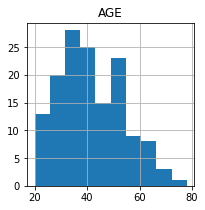

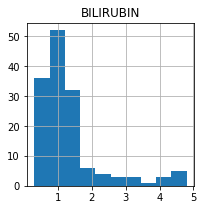

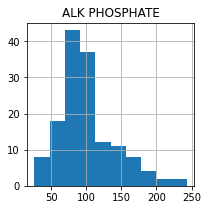

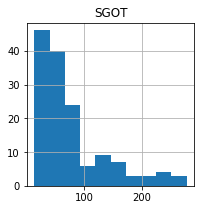

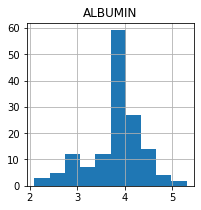

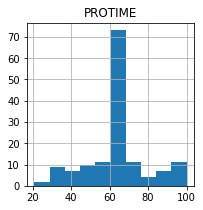

In [14]:
### creating histograms for columns with non-boolean values

for col in non_bool_col:
  hep_df.hist(column = col, figsize = (3,3))

### Messidor Features

In [15]:
### creating the dataframe for messidor_features.arff

# loads in the arff data
mess_data = arff.loadarff('messidor_features.arff')
# creates a dataframe from the .arff file
mess_df = pd.DataFrame(mess_data[0])

# moves the target "Class" column to the beginning of the dataframe
class_col = mess_df.pop('Class')
mess_df.insert(0, 'Class', class_col)

In [16]:
### cleaning the data in mess_df

# columns with boolean values
bool_cols = ['0', '1', '18']

# ensures the columns with boolean values save as integers
for col in bool_cols:
  mess_df[col] = mess_df[col].astype('int64')

# resaving the boolean values in the Class column from objects to ints
mess_df['Class'] = mess_df['Class'].map({b'0':0, b'1':1}).astype('int64')

mess_df = remove_outliers(mess_df)

In [17]:
mess_df

,Class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,1,1,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1
1,0,1,1,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0
2,1,1,1,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0
3,0,1,1,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0
4,1,1,1,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0,1,1,35.0,34.0,33.0,33.0,33.0,26.0,2.579859,0.001552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537551,0.124181,0
1146,0,1,1,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0
1147,0,1,1,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0
1149,1,1,1,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1


### Analysis of Messidor Features

In [18]:
### finding the most correlated features with Class column (target)

# creates correlation dataframe
correlation_df = mess_df.corr()

# removes the first row of the correlation dataframe
class_correlation = (correlation_df).iloc[1:, 0:1]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'Class')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,Class
2,0.282618
3,0.254831
4,0.224684


In [19]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'Class')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,Class
9,-0.064864
10,-0.030217
18,-0.023560


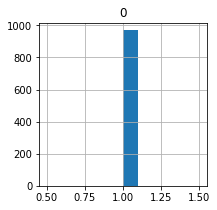

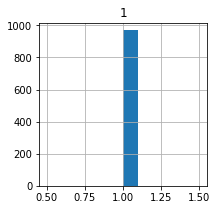

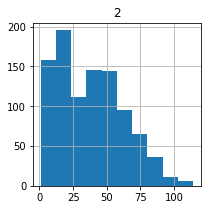

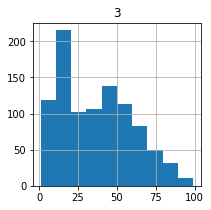

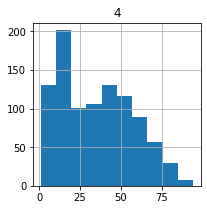

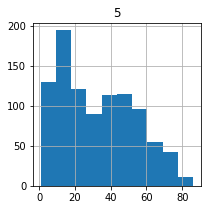

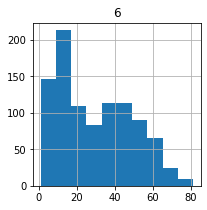

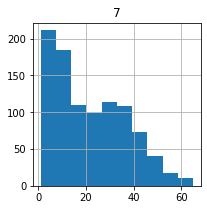

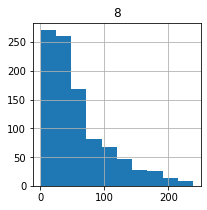

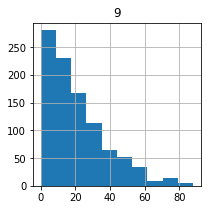

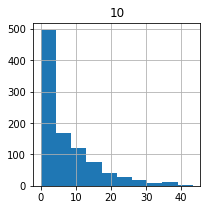

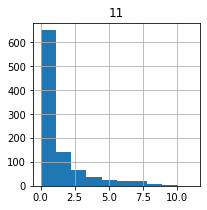

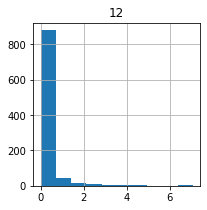

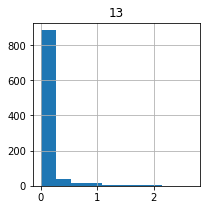

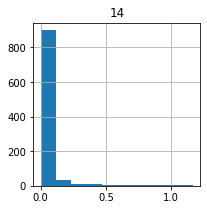

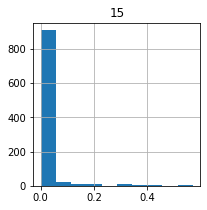

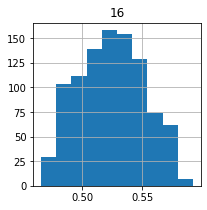

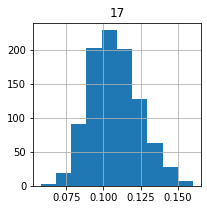

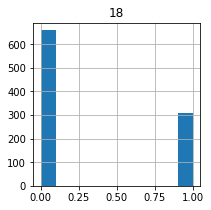

In [20]:
### creating histograms for each value

for col in mess_df:
  if col != "Class":
    mess_df.hist(column = col, figsize = (3,3))

## Helper functions

In [21]:
### function to split the data

# assumes the first column of the df is the target label
def train_test_split(df):

  # shuffling the order of rows in the input dataframe
  df = df.sample(frac = 1, random_state = 1)

  # splits the input dataframe into arrays of instances and labels
  x, y = df.iloc[:, 1:].to_numpy(), df.iloc[:, 0].to_numpy()

  # the number of data points
  instance_count = x.shape[0]

  # the number of instances to be used in the training data
  train_count = int((instance_count/3)*2)

  # splitting the data into training data and labels,
  # and testing data and labels
  x_train, y_train = x[:train_count], y[:train_count]
  x_test, y_test = x[train_count:], y[train_count:]

  return x_train, y_train, x_test, y_test

In [22]:
### accuracy-evaluating function

def evaluate_acc(true_labels, target_labels):

  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances
  # divided by the total amount
  accuracy = np.sum(true_labels == target_labels)/label_count


  return accuracy

# Implementing models

## KNN

In [23]:
# distance functions
euclidean = lambda x_train, x_test: np.sqrt(np.sum((x_train - x_test)**2, axis = -1))
manhattan = lambda x_train, x_test: np.sum(np.abs(x_train - x_test), axis = -1)
cosine = lambda x_train, x_test: np.sum(x_train * x_test, axis = -1) / ((np.sqrt(np.sum(x_train**2, axis = -1))) *(np.sqrt(np.sum(x_test**2, axis = -1))))

class KNN:
  # constructor
  def __init__(self, K = 1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K

  def fit(self, x_train, y_train):
    # stores the training data, since KNN is a lazy learner
    self.x_train = x_train
    self.y_train = y_train

    # the number of classes
    self.class_count = len(set(y_train))
    return self

  def predict(self, x_test):
    # uses the stored training data and x_test (test data passed as input)

    # the number of instances in the testing data
    instance_count = x_test.shape[0]

    # an array of the distances between the training data points and the testing
    # data points
    distances_arr = self.dist_fn(self.x_train[None, :, :], x_test[:, None, :])
    
    # initializes an array full of zeros for the k-nearest neighbours
    knn_arr = np.zeros((instance_count, self.K), dtype = int)
    # initializes an array full of zeros for the class probabilities
    class_prob = np.zeros((instance_count, self.class_count))

    # iterates through each instance in the testing data
    for instance in range(instance_count):
      # the i-th index is an array with the k-nearest neighbours in x_train to
      # data point i in x_test
      knn_arr[instance, :] = np.argsort(distances_arr[instance])[:self.K]
      
      # the i-th index is an array counting the occurrence of each
      # class type for data point i in x_test where the j-th index of the 
      # sub-array represents the number of neighbours in x_train of class j
      class_prob[instance, :] = np.bincount(self.y_train[knn_arr[instance,:]], minlength = self.class_count)
      #print(self.y_train[knn_arr[instance, :]].dtype)

    # divides all probabilities by the number of neighbours to look for
    class_prob /= self.K

    return class_prob, knn_arr


## Decision Tree

### Node

In [24]:
class Node:
  def __init__(self, instance_indices, parent):

    # the indices of the instances (in the data) within this region of the DT
    self.instance_indices = instance_indices
    self.left = None
    self.right = None
    self.split_feature = None
    self.split_val = None

    # if the node has a parent
    if parent:
      self.depth = parent.depth + 1
      self.class_count = parent.class_count
      
      # pointer to original data
      self.data = parent.data
      self.labels = parent.labels
      class_prob = np.bincount(self.labels[instance_indices], minlength = self.class_count)
      self.class_prob = class_prob / np.sum(class_prob)

### Greedy Split

In [25]:
def greedy_split(node, cost_fn):
  # if the split cannot be made, returns infinity
  best_cost = np.inf
  best_feature, best_value = None, None
  instance_count, feature_count = node.data.shape
  best_split = None

  # sorts the data within each column then saves boundary values in test_splits
  sorted_data = np.sort(node.data[node.instance_indices], axis = 0)
  test_splits = (sorted_data[1:] + sorted_data[:-1]) / 2

  for feature in range(feature_count):
    feature_data = node.data[node.instance_indices, feature]

    if(len(set(feature_data)) == 2):
      left_indices = node.instance_indices[feature_data == 0]
      right_indices = node.instance_indices[feature_data == 1]

    else:
      for split in test_splits[:, feature]:
        left_indices = node.instance_indices[feature_data <= split]
        right_indices = node.instance_indices[feature_data > split]

        if (len(left_indices) == 0) or (len(right_indices) == 0):
          continue

      left_cost = cost_fn(node.labels[left_indices])
      right_cost = cost_fn(node.labels[right_indices])

      left_count, right_count = left_indices.shape[0], right_indices.shape[0]
      cost = ((left_count * left_cost) + (right_count * right_cost)) / instance_count

      if cost < best_cost:
        best_cost = cost
        best_feature = feature
        best_split = split

  return best_cost, best_feature, best_split

### Cost Functions

In [26]:
### cost functions

def misclassification_cost(labels):
  most_frequent_label = np.argmax(labels)
  cost = sum(1 for label in labels if label != most_frequent_label)
  return cost

def entropy_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for label in unique_labels:
    cur_labels = sum(1 for label in unique_labels)
    ratio = cur_labels / label_count
    cost += ratio * np.log2(ratio)

  cost *= -1
  return cost

def gini_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for label in unique_labels:
    cur_labels = sum(1 for label in unique_labels)
    ratio = cur_labels / label_count
    cost += np.square(ratio)

  cost = 1 - cost
  return cost

### DT model implementations

In [27]:
### the tree stops splitting if
### 1) there are not enough points under the current node (min_instances)
### 2) maximum depth reached (max_depth)
### 3) decrease in cost is negligible

class DT:
  def __init__(self, class_count = None, max_depth = 3, cost_fn = entropy_cost, min_instances = 1):
    self.root = None
    self.max_depth = max_depth
    self.cost_fn = cost_fn
    self.class_count = class_count
    self.min_instances = min_instances

  def fit(self, data, labels):
    self.data = data
    self.labels = labels

    if self.class_count is None:
      self.class_count = len(set(labels))

    # root
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.class_count = self.class_count
    self.root.depth = 0

    # builds the rest of the tree
    self.fit_recursive(self.root)

    return self

  def fit_recursive(self, node):
    max_depth_reached = node.depth == self.max_depth
    insufficient_instances = len(node.instance_indices) <= self.min_instances

    # if the maximum depth was reached
    if max_depth_reached or insufficient_instances:
      return

    cost, split_feature, split_value = greedy_split(node, self.cost_fn)

    # it's not possible to split
    if np.isinf(cost):
      return

    left_split_indices = node.data[node.instance_indices, split_feature] <= split_value

    node.split_feature = split_feature
    node.split_value = split_value

    # new nodes
    new_left = Node(node.instance_indices[left_split_indices], node)
    new_right = Node(node.instance_indices[np.logical_not(left_split_indices)], node)

    # recursive call
    self.fit_recursive(new_left)
    self.fit_recursive(new_right)

    node.left = new_left
    node.right = new_right

  def predict(self, x_test):
    # initializing empty array
    class_probs = np.zeros((x_test.shape[0], self.class_count))

    for instance_num, instance_features in enumerate(x_test):
      node = self.root
      
      while node.left:
        if instance_features[node.split_feature] <= node.split_value:
          node = node.left
        else:
          node = node.right

      # while loop terminates when you reach a leaf of the tree
      # the class probability of that node is taken for prediction
      class_probs[instance_num, :] = node.class_prob

    return class_probs

# Decision Trees

In order to build the decision tree class we need to implement various components:


*   Nodes to describe the structure
*   Cost function to evaluate a split and choose the best feature
*   Greedy test (can be heuristic) to do the selection

## Node:

In [77]:
##This implementation is derrived from code found in DecisionTree.ipynb from the class's GitHub 

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the indices of the data in the region of this node
        self.left = None                                    #stores the left child of this node 
        self.right = None                                   #stores the right child of this node

        #Splitting parameters
        self.split_feature = None                           #the feature being split at this node (data[f])
        self.split_value = None                             #the value that splits the data at this node. (data[f] <= value)

        #data passed from the parent
        if parent:
            self.depth = parent.depth + 1                   #this node's depth is 1 more than the parent's 
            self.num_classes = parent.num_classes           #copies the num classes from the parent which will be the same for all nodes
            self.data = parent.data                         #copies the data from the parent 
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

## Cost functions

In [78]:
#several different cost functions are implemented here 

#misclassification
def cost_misclassification(labels):
  #find the highest count (which will be how they are all labelled) 
  correct_Perc = np.max(np.bincount(labels))/len(labels) #find which label has the highest count then divide by the total number of samples in labels to find the frequency of correctly classified
  return 1- correct_Perc # return the percent of missclassified

#entropy of the labels by computing the class probabilities
def cost_entropy(labels):
  class_probs = np.bincount(labels) / len(labels)      #calculate class probabilities by dividing the # of each class by the total number
  class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
  return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)      #calculate class probabilities by dividing the # of each class by the total number
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

##Greedy Test

In [83]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values (at the start there aren't any)
    min_cost = np.inf 
    best_feature, best_value = None, None

    num_instances, num_features = node.data.shape #the number of instances is equal to the number of rows in the data, #features is equal to the # columns

    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2. #gives each combination of left and right segments of the sorted data
    #ex: i = [1,2,3,4,5], test_cand = [1.5, 2.5, 3.5, 4.5]

    for d in range(num_features):
      #stores the data corresponding to the d-th feature
      data_d = node.data[node.data_indices, d]

      for val in test_candidates[:, d]: #for each value of a given feature
        #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_d <= val]
            right_indices = node.data_indices[data_d > val]

            #we can't have a split where a child has zero element (it would pretty much result in the same node again)
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue

            left_cost = cost_fn(node.labels[left_indices]) #calculate cost for the left side
            right_cost = cost_fn(node.labels[right_indices]) #calculate cost for the right side


            num_left, num_right = left_indices.shape[0], right_indices.shape[0] # weighted cost = cost * numElements / totalnumElements
            #get the combined cost using the weighted sum of left and right cost for the cuurent test value and feature
            cost = (num_left * left_cost + num_right * right_cost)/num_instances 
            
            #update only when a lower cost is encountered
            if cost < min_cost:
                min_cost = cost
                best_feature = d
                best_value = val
    return min_cost, best_feature, best_value

## Decision Tree class. We are now ready to implement the fit and predict functions

In [80]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
      self.max_depth = max_depth      #maximum dept for termination 
      self.root = None                #stores the root of the decision tree 
      self.cost_fn = cost_fn          #stores the cost function of the decision tree 
      self.num_classes = num_classes  #stores the total number of classes
      self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination


    def fit(self, data, labels):
      self.data = data
      self.labels = labels
      if self.num_classes is None:
        self.num_classes = np.max(labels) + 1 #assumes the labels start at 0

        #below are initialization of the root of the decision tree
      self.root = Node(np.arange(data.shape[0]), None) #root should include all data indices and should not have a parent
      self.root.data = data
      self.root.labels = labels
      self.root.num_classes = self.num_classes
      self.root.depth = 0
      #to recursively build the rest of the tree
      self._fit_tree(self.root)
      return self


    def _fit_tree(self, node):

      #This gives the condition for termination of the recursion resulting in a leaf node
      if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
        #greedily select the best test by minimizing the cost
      cost, split_feature, split_value = greedy_test(node, self.cost_fn)

          #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
      if np.isinf(cost):
        return

          #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
      test = node.data[node.data_indices,split_feature] <= split_value
          #store the split feature and value of the node
      node.split_feature = split_feature
      node.split_value = split_value
          #define new nodes which are going to be the left and right child of the present node
      left = Node(node.data_indices[test], node)
      right = Node(node.data_indices[np.logical_not(test)], node)
          #recursive call to the _fit_tree()
      self._fit_tree(left)
      self._fit_tree(right)
          #assign the left and right child to present child    
      node.left = left
      node.right = right
            
    def predict(self, data_test):
      pass

Next we have to define the predict function

In [81]:
def predict(self, data_test):

    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# Running experiments

## KNN experiments

### Baseline accuracy test

In [33]:
### running KNN on hep_df data for all data

# splits the data
x_train, y_train, x_test, y_test = train_test_split(hep_df)

# creates a new KNN model
knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most likely class labels for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

The accuracy of the model is: 75.51%


In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1) # n_neighbors=5 (default)
fit = knn.fit(x_train, y_train)
pred_y = fit.predict(x_test)
evaluate_acc(y_test, pred_y)

0.7959183673469388

In [35]:
### running KNN on mess_df data

x_train, y_train, x_test, y_test = train_test_split(mess_df)

knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

The accuracy of the model is: 62.54%


### Acurracy test with removed low correlation features

The accuracy of the model is: 85.71%


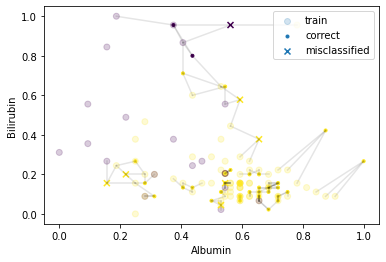

In [36]:
### running KNN on hep_df data for top 2 features

hep_cut_df = normalize_df(hep_df[['CLASS', 'ALBUMIN', 'BILIRUBIN']])

# splits the data
x_train, y_train, x_test, y_test = train_test_split(hep_cut_df)

# creates a new KNN model
knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most likely class labels for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

for i in range(x_test.shape[0]):
  for k in range(knn_model.K):

    hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
    ver = x_test[i, 1], x_train[knn_arr[i, k], 1]

    plt.plot(hor, ver, 'k-', alpha = 0.1)

plt.xlabel('Albumin')
plt.ylabel('Bilirubin')
plt.legend()
plt.show()

The accuracy of the model is: 51.7%


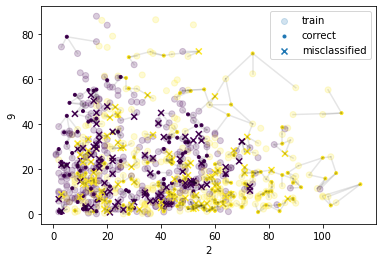

In [37]:
### running KNN on mess_df data for top 2 correlated features

mess_cut_df = mess_df[['Class', '2', '9']]

x_train, y_train, x_test, y_test = train_test_split(mess_cut_df)

knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

for i in range(x_test.shape[0]):
  for k in range(knn_model.K):

    hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
    ver = x_test[i, 1], x_train[knn_arr[i, k], 1]

    plt.plot(hor, ver, 'k-', alpha = 0.1)

plt.xlabel('2')
plt.ylabel('9')
plt.legend()
plt.show()

### Testing different values for K

We must first create a validation set

In [38]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)
x = hep_df.iloc[:, :-1].to_numpy()
y = np.ravel((hep_df.iloc[:, -1:]).to_numpy())
#now we can divide the data into 3 sections: training, validation, testing

x_tr, x_tst, y_tr, y_tst =   train_test_split(x, y, test_size=0.2, random_state=11)


x_tr, x_valid, y_tr, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=11)


best K = 1, test accuracy = 0.7241379310344828


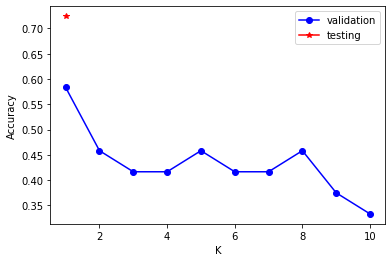

In [39]:

model_choices=[]
valid_acc = []

n_valid = y_valid.shape[0]

for k in range(1,11):
    knn = KNN(K=k) # create a KNN object 
    y_train_va_prob,_ = knn.fit(x_tr, y_tr).predict(x_valid)
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
    accuracy = np.sum(y_train_va_pred == y_valid)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob,_ = knn.fit(x_tr, y_tr).predict(x_tst)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_tst)/y_tst.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

In [40]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)
x = mess_df.iloc[:, :-1].to_numpy()
y = np.ravel((mess_df.iloc[:, -1:]).to_numpy())
#now we can divide the data into 3 sections: training, validation, testing

x_tr, x_tst, y_tr, y_tst =   train_test_split(x, y, test_size=0.2, random_state=11)


x_tr, x_valid, y_tr, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=11)


best K = 7, test accuracy = 0.7422680412371134


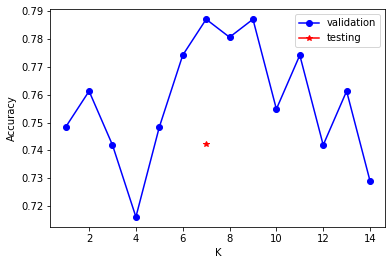

In [41]:

model_choices=[]
valid_acc = []

n_valid = y_valid.shape[0]

for k in range(1,15):
    knn = KNN(K=k) # create a KNN object 
    y_train_va_prob,_ = knn.fit(x_tr, y_tr).predict(x_valid)
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
    accuracy = np.sum(y_train_va_pred == y_valid)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob,_ = knn.fit(x_tr, y_tr).predict(x_tst)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_tst)/y_tst.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

### Using different distance functions

In [42]:
### running KNN on hep_df data for all data

# splits the data
x_train, y_train, x_test, y_test = train_test_split(hep_df)

def distTest(k, function, x_train, y_train, x_test, y_test):
  # creates a new KNN model using euclidean distance
  knn_model = KNN(K = k, dist_fn=function)
  # fits the model to the training data, then tests the model on the test
  # data for K = 3
  class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)
  # outputs an array of the most likely class labels for each instance in x_test
  class_pred = np.argmax(class_prob, axis = -1)
  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)
  return accuracy

euclid1_accuracy = distTest(k=1, function = euclidean, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
manhat1_accuracy = distTest(k=1, function = manhattan, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

euclid3_accuracy = distTest(k=3, function = euclidean, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
manhat3_accuracy = distTest(k=3, function = manhattan, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

euclid5_accuracy = distTest(k=5, function = euclidean, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
manhat5_accuracy = distTest(k=5, function = manhattan, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

print("k = 1")
print("The accuracy of the euclidean model is: " + str(round((euclid1_accuracy * 100), 2)) + "%")
print("The accuracy of the manhattan model is: " + str(round((manhat1_accuracy * 100), 2)) + "%")

print("k = 3")
print("The accuracy of the euclidean model is: " + str(round((euclid3_accuracy * 100), 2)) + "%")
print("The accuracy of the manhattan model is: " + str(round((manhat3_accuracy * 100), 2)) + "%")

print("k = 5")
print("The accuracy of the euclidean model is: " + str(round((euclid5_accuracy * 100), 2)) + "%")
print("The accuracy of the manhattan model is: " + str(round((manhat5_accuracy * 100), 2)) + "%")

ValueError: ignored

In [ ]:
### using different dist functions on mess_df
x_train, y_train, x_test, y_test = train_test_split(mess_df)

euclid1_accuracy = distTest(k=1, function = euclidean, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
manhat1_accuracy = distTest(k=1, function = manhattan, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

euclid3_accuracy = distTest(k=3, function = euclidean, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
manhat3_accuracy = distTest(k=3, function = manhattan, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

euclid5_accuracy = distTest(k=5, function = euclidean, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
manhat5_accuracy = distTest(k=5, function = manhattan, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

print("k = 1")
print("The accuracy of the euclidean model is: " + str(round((euclid1_accuracy * 100), 2)) + "%")
print("The accuracy of the manhattan model is: " + str(round((manhat1_accuracy * 100), 2)) + "%")

print("k = 3")
print("The accuracy of the euclidean model is: " + str(round((euclid3_accuracy * 100), 2)) + "%")
print("The accuracy of the manhattan model is: " + str(round((manhat3_accuracy * 100), 2)) + "%")

print("k = 5")
print("The accuracy of the euclidean model is: " + str(round((euclid5_accuracy * 100), 2)) + "%")
print("The accuracy of the manhattan model is: " + str(round((manhat5_accuracy * 100), 2)) + "%")

### Decision Boundaries

To plot decision boundaries, we will use the best two features to fit the model and predict it. We do so because it would not be possible to plot all features on a 2d graph. Alternatively we could have chosen to use dimensionality reduction but we believe this serves to better illustrate the effects of the most important features.

[[4.  1. ]
 [3.5 0.9]
 [4.  0.7]
 [4.  0.7]
 [4.  1. ]]
[0 0 0 0 0]
145
145


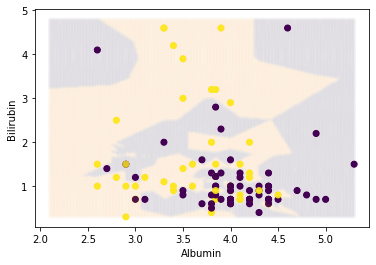

In [72]:
### plotting decision boundary
#Here we use a subset of the data to only include the two best features that were found earlier

x_db = hep_df[["ALBUMIN", "BILIRUBIN"]].to_numpy()
y_db = np.ravel((hep_df.iloc[:, -1:]).to_numpy())
print(x_db[:5])
print(y_db[:5])


def dbDraw(x,y, x0label, x1label):
  x_tr, x_tst, y_tr, y_tst =   train_test_split(x, y, test_size=0.2, random_state=11)

  #we can make the grid finer by increasing the number of samples from 200 to higher value
  x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
  x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

  # to features values as a mesh  
  x0, x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  #Number of classes:
  C = np.max(y)+1
  # Getting coloring for y
  y_train_prob = np.zeros((y_tr.shape[0], C))
  y_train_prob[np.arange(y_tr.shape[0]), y_tr] = 1

  model = KNN(K = 1)
  #to get class probability of all the points in the 2D grid
  y_prob_all, _ = model.fit(x_tr, y_tr).predict(x_all)
  y_pred_all = np.argmax(y_prob_all,axis=-1)

  #lastly we need to graph the results
  plt.scatter(x_tr[:,0], x_tr[:,1], c=y_tr, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
  plt.ylabel(x1label)
  plt.xlabel(x0label)
  plt.show()

print(len(x_db))
print(len(y_db))
dbDraw(x_db, y_db, "Albumin", "Bilirubin")

[[22.       49.895756]
 [24.       57.709936]
 [62.       55.831441]
 [55.       40.467228]
 [44.       18.026254]]
[0 0 1 0 1]


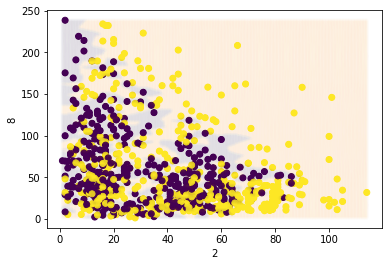

In [73]:
x_db = mess_df[["2", "8"]].to_numpy()
y_db = mess_df["Class"].to_numpy()

dbDraw(x_db, y_db, "2", "8")

## DT experiments

Baseline accuracy tests

In [ ]:
### running DT on hepatitis.data

x_train, y_train, x_test, y_test = train_test_split(df = hep_df)

dt_model = DecisionTree(max_depth = 10)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_probs = dt_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_probs, axis = 1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print(accuracy)


In [ ]:
### running DT on messidor_features.arff

x_train, y_train, x_test, y_test = train_test_split(df = mess_df)

dt_model = DecisionTree(max_depth = 10)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_probs = dt_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_probs, axis = 1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print(accuracy)

### Testing different values for maximum tree depth

In [ ]:
#Hep data
from sklearn.model_selection import train_test_split
np.random.seed(1234)
X = hep_df.iloc[:, :-1].to_numpy()
Y = np.ravel((hep_df.iloc[:, -1:]).to_numpy())

def testDifDepth(x, y):
  #now we can divide the data into 3 sections: training, validation, testing

  x_tr, x_tst, y_tr, y_tst =   train_test_split(x, y, test_size=0.2, random_state=11)
  x_tr, x_valid, y_tr, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=11)
  

  ### choise of max depth
  model_choices=[]
  train_acc = []
  valid_acc = []

  n_train = y_tr.shape[0]
  n_valid = y_valid.shape[0]

  for k in range(1, 15):
      dt = DecisionTree(max_depth=k, cost_fn=cost_gini_index) # create a KNN object (OOP)

      y_train_tr_prob = dt.fit(x_tr, y_tr).predict(x_tr)
      y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
      acc_tr = np.sum(y_train_tr_pred == y_tr)/n_train

      y_train_va_prob = dt.fit(x_tr, y_tr).predict(x_valid)
      y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
      acc_va = np.sum(y_train_va_pred == y_valid)/n_valid

      model_choices.append(k)
      train_acc.append(acc_tr)
      valid_acc.append(acc_va)

  # use the best K to predict test data
  best_depth = model_choices[valid_acc.index(max(valid_acc))]
  dt = DecisionTree(max_depth=best_depth, cost_fn=cost_gini_index)
  y_test_prob = dt.fit(x_train, y_train).predict(x_tst)

 

  y_test_pred = np.argmax(y_test_prob, axis=-1)
 
  test_accuracy = np.sum(y_test_pred == y_tst)/y_tst.shape[0]
  print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')

  plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
  plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
  plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
  plt.xlabel("Tree depth")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.savefig('iris_DT_chooseDepth.png',dpi=300,bbox_inches='tight')

testDifDepth(X, Y)

In [ ]:
### Messador data
np.random.seed(123)
X = mess_df.iloc[:, :-1].to_numpy()
Y = np.ravel((mess_df.iloc[:, -1:]).to_numpy())

testDifDepth(X, Y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier



np.random.seed(123)
x = mess_df.iloc[:, :-1].to_numpy()
y = np.ravel((mess_df.iloc[:, -1:]).to_numpy())
#now we can divide the data into 3 sections: training, validation, testing

x_tr, x_tst, y_tr, y_tst =   train_test_split(x, y, test_size=0.2, random_state=11)
x_tr, x_valid, y_tr, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=11)


### choise of max depth
model_choices=[]
valid_acc = []

n_valid = y_valid.shape[0]

for k in range(1,15):
    dt_model = DecisionTreeClassifier(max_depth = k, ) # create a KNN object 
    fit = dt_model.fit(x_tr, y_tr)
    y_train_va_prob = fit.predict(x_valid)
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
    accuracy = np.sum(y_train_va_pred == y_valid)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTreeClassifier(max_depth=best_valid_K)
y_test_pred  = dt.fit(x_tr, y_tr).predict(x_tst)

test_accuracy = np.sum(y_test_pred == y_tst)/y_tst.shape[0]
print(y_test_pred)
print(y_tst)
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

### Using different cost functions

In [ ]:
### running KNN on hep_df data for all data

# splits the data
x_train, y_train, x_test, y_test = train_test_split(hep_df)

def costTest(k, function, x_train, y_train, x_test, y_test):
  # creates a new KNN model using euclidean distance
  dt_model = DecisionTree(max_depth= k, cost_fn= function)
  # fits the model to the training data, then tests the model on the test
  # data for K = 3
  class_prob = dt_model.fit(x_train, y_train).predict(x_test)
  # outputs an array of the most likely class labels for each instance in x_test
  class_pred = np.argmax(class_prob, axis = -1)
  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)
  return accuracy

GI1_accuracy = costTest(k=1, function = cost_gini_index, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
miss1_accuracy = costTest(k=1, function = cost_misclassification, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
ent1_accuracy = costTest(k=1, function = cost_entropy, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

GI3_accuracy = costTest(k=3, function = cost_gini_index, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
miss3_accuracy = costTest(k=3, function = cost_misclassification, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
ent3_accuracy = costTest(k=3, function = cost_entropy, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

GI5_accuracy = costTest(k=5, function = cost_gini_index, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
miss5_accuracy = costTest(k=5, function = cost_misclassification, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
ent5_accuracy = costTest(k=5, function = cost_entropy, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

print("k = 1")
print("The accuracy of the gini model is: " + str(round((GI1_accuracy * 100), 2)) + "%")
print("The accuracy of the missclasification model is: " + str(round((miss1_accuracy * 100), 2)) + "%")
print("The accuracy of the entropy model is: " + str(round((ent1_accuracy * 100), 2)) + "%")

print("k = 3")
print("The accuracy of the gini model is: " + str(round((GI3_accuracy * 100), 2)) + "%")
print("The accuracy of the missclasification model is: " + str(round((miss3_accuracy * 100), 2)) + "%")
print("The accuracy of the entropy model is: " + str(round((ent3_accuracy * 100), 2)) + "%")

print("k = 5")
print("The accuracy of the gini model is: " + str(round((GI5_accuracy * 100), 2)) + "%")
print("The accuracy of the missclasification model is: " + str(round((miss5_accuracy * 100), 2)) + "%")
print("The accuracy of the entropy model is: " + str(round((ent5_accuracy * 100), 2)) + "%")

In [ ]:
# splits the data
x_train, y_train, x_test, y_test = train_test_split(mess_df)
GI1_accuracy = costTest(k=1, function = cost_gini_index, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
miss1_accuracy = costTest(k=1, function = cost_misclassification, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
ent1_accuracy = costTest(k=1, function = cost_entropy, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

GI3_accuracy = costTest(k=3, function = cost_gini_index, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
miss3_accuracy = costTest(k=3, function = cost_misclassification, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
ent3_accuracy = costTest(k=3, function = cost_entropy, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

GI5_accuracy = costTest(k=5, function = cost_gini_index, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
miss5_accuracy = costTest(k=5, function = cost_misclassification, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)
ent5_accuracy = costTest(k=5, function = cost_entropy, x_train = x_train, y_train = y_train, x_test= x_test, y_test=y_test)

print("k = 1")
print("The accuracy of the gini model is: " + str(round((GI1_accuracy * 100), 2)) + "%")
print("The accuracy of the missclasification model is: " + str(round((miss1_accuracy * 100), 2)) + "%")
print("The accuracy of the entropy model is: " + str(round((ent1_accuracy * 100), 2)) + "%")

print("k = 3")
print("The accuracy of the gini model is: " + str(round((GI3_accuracy * 100), 2)) + "%")
print("The accuracy of the missclasification model is: " + str(round((miss3_accuracy * 100), 2)) + "%")
print("The accuracy of the entropy model is: " + str(round((ent3_accuracy * 100), 2)) + "%")

print("k = 5")
print("The accuracy of the gini model is: " + str(round((GI5_accuracy * 100), 2)) + "%")
print("The accuracy of the missclasification model is: " + str(round((miss5_accuracy * 100), 2)) + "%")
print("The accuracy of the entropy model is: " + str(round((ent5_accuracy * 100), 2)) + "%")

### Decision Boundaries

To plot decision boundaries, we will use the best two features to fit the model and predict it. We do so because it would not be possible to plot all features on a 2d graph. Alternatively we could have chosen to use dimensionality reduction but we believe this serves to better illustrate the effects of the most important features.

[[4.  1. ]
 [3.5 0.9]
 [4.  0.7]
 [4.  0.7]
 [4.  1. ]]
[0 0 0 0 0]
145
145


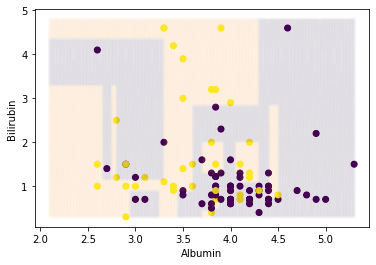

In [85]:
### plotting decision boundary
#Here we use a subset of the data to only include the two best features that were found earlier

x_db = hep_df[["ALBUMIN", "BILIRUBIN"]].to_numpy()
y_db = np.ravel((hep_df.iloc[:, -1:]).to_numpy())
print(x_db[:5])
print(y_db[:5])


def dbDraw(x,y, x0label, x1label):
  x_tr, x_tst, y_tr, y_tst =   train_test_split(x, y, test_size=0.2, random_state=11)

  #we can make the grid finer by increasing the number of samples from 200 to higher value
  x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
  x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

  # to features values as a mesh  
  x0, x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  #Number of classes:
  C = np.max(y)+1
  # Getting coloring for y
  y_train_prob = np.zeros((y_tr.shape[0], C))
  y_train_prob[np.arange(y_tr.shape[0]), y_tr] = 1

  model = DecisionTree(max_depth= 10, cost_fn=cost_gini_index)
  #to get class probability of all the points in the 2D grid
  y_prob_all = model.fit(x_tr, y_tr).predict(x_all)
  y_pred_all = np.argmax(y_prob_all,axis=-1)

  #lastly we need to graph the results
  plt.scatter(x_tr[:,0], x_tr[:,1], c=y_tr, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
  plt.ylabel(x1label)
  plt.xlabel(x0label)
  plt.show()

print(len(x_db))
print(len(y_db))
dbDraw(x_db, y_db, "Albumin", "Bilirubin")

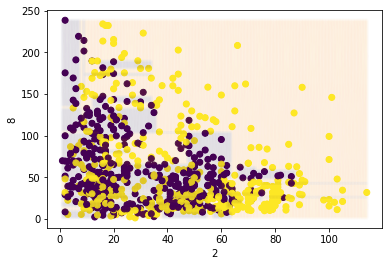

In [86]:
x_db = mess_df[["2", "8"]].to_numpy()
y_db = mess_df["Class"].to_numpy()

dbDraw(x_db, y_db, "2", "8")